# Image Segmentation using GrabCut

*   Akshay Bankar (2019201011)

> Import required libraries



In [1]:
!pip3 install python-igraph

     |████████████████████████████████| 3.2MB 2.8MB/s 


In [0]:
import numpy as np
import cv2
import glob
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
import igraph
from copy import deepcopy
import matplotlib.pyplot as plt

### GMM implementation

In [0]:
from sklearn.cluster import KMeans
import numpy as np

class GaussianMixture:
    def __init__(self, X, n_components=5):
        self.n_components = n_components
        self.n_features = X.shape[1]
        self.n_samples = np.zeros(self.n_components)
        
        ## pi- mixing coefficient matrix
        self.coefs = np.zeros(self.n_components)
        ## means of n_components gaussains
        self.means = np.zeros((self.n_components, self.n_features))
        ## covariances matrices of n_component gaussians
        self.covariances = np.zeros((self.n_components, self.n_features,
                                     self.n_features))
        #print(X.shape)
        ## 
        self.init_with_kmeans(X)

    def init_with_kmeans(self, X):
        ## initialize KMeans with n_components and get labels of each point
        label = KMeans(n_clusters=self.n_components, n_init=1).fit(X).labels_
        ## Compute k-means clustering
        self.fit(X, label)

    def calc_score(self, X, ci):
        score = np.zeros(X.shape[0])
        if self.coefs[ci] > 0:
            diff = X - self.means[ci]
            mult = np.einsum(
                'ij,ij->i', diff,
                np.dot(np.linalg.inv(self.covariances[ci]), diff.T).T)
            score = np.exp(-.5 * mult) / np.sqrt(2 * np.pi) / \
                np.sqrt(np.linalg.det(self.covariances[ci]))

        return score

    def calc_prob(self, X):
        prob = [self.calc_score(X, ci) for ci in range(self.n_components)]
        return np.dot(self.coefs, prob)

    def which_component(self, X):
        prob = np.array(
            [self.calc_score(X, ci) for ci in range(self.n_components)]).T
        return np.argmax(prob, axis=1)

    def fit(self, X, labels):
        assert self.n_features == X.shape[1]

        self.n_samples[:] = 0
        self.coefs[:] = 0

        uni_labels, count = np.unique(labels, return_counts=True)
        self.n_samples[uni_labels] = count

        variance = 0.01
        for ci in uni_labels:
            n = self.n_samples[ci]

            self.coefs[ci] = n / np.sum(self.n_samples)
            self.means[ci] = np.mean(X[ci == labels], axis=0)
            self.covariances[ci] = 0 if self.n_samples[ci] <= 1 else np.cov(
                X[ci == labels].T)

            det = np.linalg.det(self.covariances[ci])
            if det <= 0:
                self.covariances[ci] += np.eye(self.n_features) * variance
                det = np.linalg.det(self.covariances[ci])

### GrabCut

> The Grab Cut method segmentation of object from background in a colored image,given certain constraints. The user is requested to mark a single rectangle around the object, defining the outer part of the rectangle as definite background, and the inner part of it as an unknown combination of the object (foreground) and some background. These constraints are used as initial solution to the problem, leading to an iterative method which in conclusion aims to assign each pixel in the image its label - Background or Foreground.

> Energy function : The function has 2 parts - Data term & Smoothness term.


> ![alt text](https://drive.google.com/uc?id=1qDh-1QTS_ef1_apzuUtd6kGVHfwT0kGw)


*   Data term : The data term measures how well we fit a certain model - in our case, the color distribution. For every pixel we take its label alpha & color Z,and use it as inputs to see well it matches a color distribution model using h(). In this case, the model is a K-Gaussian Mixture Model.

>  ![alt text](https://drive.google.com/uc?id=10yG2QyuZ6kM1K0tmTnpkiI0WXk4v5qM7)

*   Smoothness term : This measures how smooth the labeling is over similar/a-similar neighboring pixels. For each neighboring pair that do not have the same label we increase the energy function according to a parameter Beta that lies in the exponent and effectively determines how smooth our labeling has to be.

> ![alt text](https://drive.google.com/uc?id=1flTLYJCfeL6j28qtp8sGS3j35tT82uef)




> ![alt text](https://drive.google.com/uc?id=1vbU9-y1PSmcySoaeiH7LkuHWREaTmFkJ)


#### Iterative graph-cut : 
To solve this optimization problem, we use the "Graph Cut" method. Creating a graph with weights as in above figure, and then running the "Min-Cut" algorithm - yields 2 groups of vertices (Each of which represents a pixel) with labeling that minimizes the cost function.





In [0]:
BG = 0
FG = 1
PR_BG = 2
PR_FG = 3

In [0]:
class Grabcut:
    def __init__ (self, ip_img, mask, rect, num_gmm = 5, gamma = 50, neighbors = 8):
        self.img = np.asarray(ip_img, dtype=np.float64)
        self.out_image = deepcopy(ip_img)
        self.rows, self.cols, _ = self.img.shape
        self.mask = mask
        if rect is not None:
            self.mask[rect[1]:rect[1] + rect[3],rect[0]:rect[0] + rect[2]] = PR_FG
        self.assign_fg_bg()
        self.gmm_comp = num_gmm
        self.gamma = gamma
        self.neighbours = neighbors
        self.calc_smoothness_term()
        
        ## Initialize fg and bg GMMs with th respective pixels as data points 
        self.fg_gmm = GaussianMixture(self.img[self.fgd_indexes], n_components = self.gmm_comp)
        self.bg_gmm = GaussianMixture(self.img[self.bgd_indexes], n_components = self.gmm_comp)
        
        ## GMM label of each pixel
        self.label_gmm = np.empty((self.rows, self.cols), dtype=np.uint32)
        
        ## Define two extra nodes of source and sink with there node numbers as n*m, n*m+1
        self.source_s = self.cols * self.rows
        self.sink_t = self.source_s + 1
        
    def assign_fg_bg(self):
        self.bgd_indexes = np.where(np.logical_or(self.mask == BG, self.mask == PR_BG))
        #print(self.fg_idx)
        self.fgd_indexes = np.where(np.logical_or(self.mask == FG, self.mask == PR_FG))
        
    def calc_smoothness_term(self):
        left_pix_diff = self.img[:, 1:] - self.img[:,:-1]
        upleft_pix_diff = self.img[1:, 1:] - self.img[:-1, :-1]
        up_pix_diff = self.img[1:, :] - self.img[:-1, :]
        upright_pix_diff = self.img[1:, :-1] - self.img[:-1, 1:]
        
        #self.beta = np.linalg.norm(left_pix_diff)**2 + np.linalg.norm(upleft_pix_diff)**2 + np.linalg.norm(up_pix_diff)**2 + np.linalg.norm(upright_pix_diff)**2
        
        self.beta = np.linalg.norm(left_pix_diff)**2 + np.linalg.norm(up_pix_diff)**2
        if self.neighbours == 8:
            self.beta += np.linalg.norm(upleft_pix_diff)**2 + np.linalg.norm(
                upright_pix_diff)**2
        #         self.beta = np.sum(np.square(left_diff)) + np.sum(np.square(up_left_diff)) + \
        #             np.sum(np.square(up_diff)) + \
        #             np.sum(np.square(up_right_diff))
        
        ## Here denominator denotes number of operations(subtractions) performed in finding expectation E
        if self.neighbours == 8:
            self.beta = 2.0 * self.beta / (4 * self.rows * self.cols - 3 *
                                           (self.rows + self.cols) + 2.0)
        else:
            self.beta = 2.0 * self.beta / (2 * self.rows * self.cols - 1 *
                                           (self.rows + self.cols) + 2.0)
        self.beta = 1 / self.beta

        #print(self.beta)
        ## gamma = 50, Find smootness term individually 
        self.left_V = self.gamma * np.exp(-self.beta * np.sum(np.square(left_pix_diff), axis=2))
        
        self.upleft_V = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(np.square(upleft_pix_diff), axis=2))
        
        self.up_V = self.gamma * np.exp(-self.beta * np.sum(np.square(up_pix_diff), axis=2))
        
        self.upright_V = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(np.square(upright_pix_diff), axis=2))
        
    def assign_GMM(self):
        ## Assign a gaussain out of n_components gaussians to each fg pix
        ## depending its argmax y=N(mu,sigma,x) value
        self.label_gmm[self.fgd_indexes] = self.fg_gmm.which_component(
            self.img[self.fgd_indexes])
        ## Assign a gaussain out of n_components gaussians to each bg pix
        ## depending its argmax y=N(mu,sigma,x) value
        self.label_gmm[self.bgd_indexes] = self.bg_gmm.which_component(
            self.img[self.bgd_indexes])

    def learn_GMM(self):
        ## Deoending on Xi's assigned to each fg gmm, update its pi,mean, cov matrix 
        self.fg_gmm.fit(self.img[self.fgd_indexes],
                         self.label_gmm[self.fgd_indexes])
        ## Deoending on Xi's assigned to each bg gmm, update its pi,mean, cov matrix 
        self.bg_gmm.fit(self.img[self.bgd_indexes],
                         self.label_gmm[self.bgd_indexes])

    def make_n_links(self, mask1, mask2, V):
        mask1 = mask1.reshape(-1)
        mask2 = mask2.reshape(-1)
        self.gc_graph_capacity += V.reshape(-1).tolist()
        return list(zip(mask1, mask2))

    def construct_gc_graph(self):
        ## Get indices (between [0,m*n], which corresponds to node number in the graph)
        ## of fg, bg and probable fg/bg
        fgd_indexes = np.where(self.mask.reshape(-1) == FG)
        bgd_indexes = np.where(self.mask.reshape(-1) == BG)
        pr_indexes = np.where((self.mask.reshape(-1) == PR_FG)
                              | (self.mask.reshape(-1) == PR_BG))

        self.gc_graph_capacity = []
        edges = []
        
        ## Function creates edges between a given node 'source' and set of nodes 'sink'
        def make_edges(source, sinks):
            return list(zip([source] * sinks[0].size, sinks[0]))
        
        ## Create edges b/w source_s and nodes(pixels) which are probable fg/bg
        edges += make_edges(self.source_s, pr_indexes)
        
        self.gc_graph_capacity += list(-np.log(
            self.bg_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes])))
        
        ## Create edges b/w sink_t and nodes(pixels) which are probable fg/bg
        edges += make_edges(self.sink_t, pr_indexes)
        ## Find the data term(U) for 'probable fg/bg' nodes as -log(p(.)) 
        ## where p(.) is gaussian probability distribution
        self.gc_graph_capacity += list(-np.log(
            self.fg_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes])))
        
        ## Create edges b/w source_s and fg nodes(pixels)
        edges += make_edges(self.source_s, fgd_indexes)
        self.gc_graph_capacity += [9 * self.gamma] * fgd_indexes[0].size

        ## Create edges b/w sink_t and fg nodes(pixels)
        edges += make_edges(self.sink_t, fgd_indexes)
        self.gc_graph_capacity += [0] * fgd_indexes[0].size
        
        ## Create edges b/w source_s and bg nodes(pixels)
        edges += make_edges(self.source_s, bgd_indexes)
        self.gc_graph_capacity += [0] * bgd_indexes[0].size
        
        ## Create edges b/w sink_t and fg nodes(pixels)
        edges += make_edges(self.sink_t, bgd_indexes)
        self.gc_graph_capacity += [9 * self.gamma] * bgd_indexes[0].size

        
        img_indexes = np.arange(
            self.rows * self.cols, dtype=np.uint32).reshape(
                self.rows, self.cols)
        
        ## Give edge weights to links which are with left node
        edges += self.make_n_links(img_indexes[:, 1:], img_indexes[:, :-1],
                                   self.left_V)
        ## Give edge weights to links which are with upper-left node
        edges += self.make_n_links(img_indexes[1:, 1:], img_indexes[:-1, :-1],
                                   self.upleft_V)
        ## Give edge weights to links which are with the upper nodes(pixels)
        edges += self.make_n_links(img_indexes[1:, :], img_indexes[:-1, :],
                                   self.up_V)
        ## Give edge weights to links which are with upper-left node(pix)
        edges += self.make_n_links(img_indexes[1:, :-1], img_indexes[:-1, 1:],
                                   self.upright_V)

        assert (len(edges) == len(self.gc_graph_capacity))
        
        ## Initialize igraph object with m*n+2 vertices
        self.gc_graph = igraph.Graph(self.rows * self.cols + 2)
        ## Add edges to the graph passed as tuple(u,v) that are formed above
        self.gc_graph.add_edges(edges)

    def estimate_segmentation(self):
        ## Perform st-mincut on the graph
        mincut = self.gc_graph.st_mincut(self.source_s, self.sink_t,
                                         self.gc_graph_capacity)
        print('foreground pixels: %d, background pixels: %d' % (len(
            mincut.partition[0]), len(mincut.partition[1])))
        ## Find the indices of the probable fg/bg from the mask
        pr_indexes = np.where((self.mask == PR_FG) | (self.mask == PR_BG))
        ## Get vertex numbers from 0 to m*n
        img_indexes = np.arange(
            self.rows * self.cols, dtype=np.uint32).reshape(
                self.rows, self.cols)
        
        ## Get the vertices which are part of 1st partition,
        ## 'condition' is True for vertices which are present in 'mincut.partition[0]'
        condition = np.isin(img_indexes[pr_indexes], mincut.partition[0])
        ## Store the values as 'PR_FG' where 'condition' is True 
        ## and 'PR_BG' at indices where the 'condition' is False
        ## i.e mark the probable (unknown) fg and bg pixels at this iteration
        self.mask[pr_indexes] = np.where(condition, PR_FG, PR_BG)
        ## Assign to pixels, there respective updated category
        self.assign_fg_bg()

    def calculate_energy(self):
        U = 0
        bg_indexes = np.where((self.mask == BG) | (self.mask == PR_BG))
        fg_indexes = np.where((self.mask == FG) | (self.mask == PR_FG))
        for component in range(self.gmm_components):
            indexes = np.where((self.label_gmm == component) & (fg_indexes))
            U += np.sum(-np.log(self.fg_gmm.coefs[component] * self.fg_gmm.
                                calc_score(self.img[indexes], component)))
            indexes = np.where((self.label_gmm == component) & (bg_indexes))
            U += np.sum(-np.log(self.bg_gmm.coefs[component] * self.bg_gmm.
                                calc_score(self.img[indexes], component)))

        V = 0
        mask = self.mask.copy()
        mask[bg_indexes] = BG
        mask[fg_indexes] = FG

        V += np.sum(self.left_V * (mask[:, 1:] == mask[:, :-1]))
        V += np.sum(self.upleft_V * (mask[1:, 1:] == mask[:-1, :-1]))
        V += np.sum(self.up_V * (mask[1:, :] == mask[:-1, :]))
        V += np.sum(self.upright_V * (mask[1:, :-1] == mask[:-1, 1:]))
        return U, V, U + V

    def modified_image(self):
        img2 = deepcopy(self.out_image)
        mask = self.mask.copy()
        mask2 = np.where((self.mask == 1) + (self.mask == 3), 255,
                         0).astype('uint8')
        #print(type(img2))
        #print(type(mask2))
        return cv2.bitwise_and(img2, img2, mask=mask2)
        
    def run(self, num_iters=2):
        for i in range(num_iters):
            ## Find argmax (y=N(mu,sig,x)), of each data point (pix) for both fg and bg pix 
            ## and  assign a Gaussain to each X depending on max y
            self.assign_GMM()
            ## Depending on assignments of Xi's to each gmmof fg and bg, update its pi, mean, cov
            self.learn_GMM()
            ## Construct graph: Create and connect nodes source, sink, fg, bg, and give them weights            
            self.construct_gc_graph()
            ## Peform st-mincut on the graph created above and 
            ## update the labels of the pixels as FG, BG, or PR_FG, PR_BG in this iteration
            self.estimate_segmentation()
            
            ########### Code to see effect of number of iterations ##########
            #print("Output after iteration ",i,":")
            #output = self.modified_image()
            #plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
            #plt.show()

In [0]:
drawing = False # true if mouse is pressed
ix,iy = -1,-1
jx, jy = -1, -1
def draw_rect(event,x,y,flags,param):
    global ix, iy, jx, jy, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.rectangle(img,(ix,iy),(x,y),(0,255,0),-1)
            jx, jy = x, y
            #return [(ix,iy), (x,y)]
            
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.rectangle(img,(ix,iy),(x,y),(0,255,0),-1)
'''
img = np.zeros((512,512,3), np.uint8)
cv2.namedWindow('image')
coord = cv2.setMouseCallback('image',draw_rect)

while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('m'):
        mode = not mode
    elif k == 27:
        break
print(ix,iy, jx,jy)
cv2.destroyAllWindows()
'''

"\nimg = np.zeros((512,512,3), np.uint8)\ncv2.namedWindow('image')\ncoord = cv2.setMouseCallback('image',draw_rect)\n\nwhile(1):\n    cv2.imshow('image',img)\n    k = cv2.waitKey(1) & 0xFF\n    if k == ord('m'):\n        mode = not mode\n    elif k == 27:\n        break\nprint(ix,iy, jx,jy)\ncv2.destroyAllWindows()\n"

## Output of all given images

*   Number of iterations = 3, Num of gmm copm =5, Num of neighbours = 8, gamma = 50



foreground pixels: 48570, background pixels: 221432
foreground pixels: 47660, background pixels: 222342
foreground pixels: 47672, background pixels: 222330


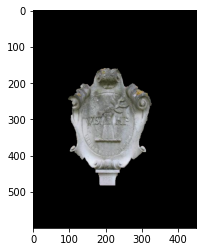

foreground pixels: 73670, background pixels: 233532
foreground pixels: 72470, background pixels: 234732
foreground pixels: 72018, background pixels: 235184


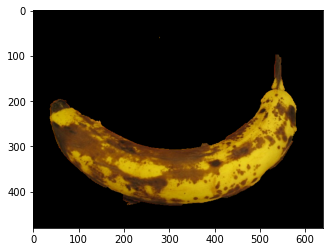

foreground pixels: 35210, background pixels: 234792
foreground pixels: 33618, background pixels: 236384
foreground pixels: 33559, background pixels: 236443


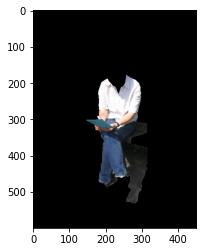

foreground pixels: 124681, background pixels: 182521
foreground pixels: 122840, background pixels: 184362
foreground pixels: 122069, background pixels: 185133


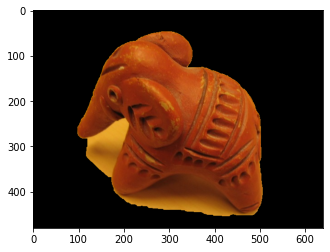

foreground pixels: 75208, background pixels: 231994
foreground pixels: 75132, background pixels: 232070
foreground pixels: 75084, background pixels: 232118


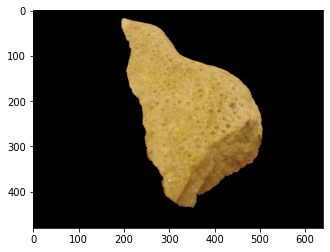

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log


foreground pixels: 108947, background pixels: 198255
foreground pixels: 104360, background pixels: 202842
foreground pixels: 102346, background pixels: 204856


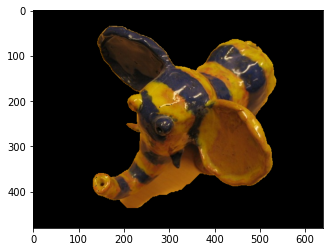

foreground pixels: 77282, background pixels: 192720
foreground pixels: 64096, background pixels: 205906
foreground pixels: 42217, background pixels: 227785


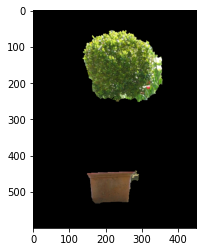

foreground pixels: 17336, background pixels: 252666
foreground pixels: 17218, background pixels: 252784
foreground pixels: 17216, background pixels: 252786


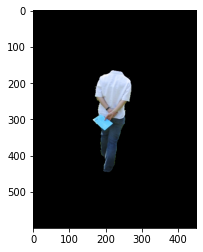

foreground pixels: 34380, background pixels: 235622
foreground pixels: 32514, background pixels: 237488
foreground pixels: 32480, background pixels: 237522


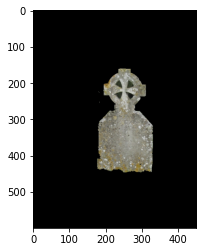

foreground pixels: 61293, background pixels: 245909
foreground pixels: 60192, background pixels: 247010
foreground pixels: 60162, background pixels: 247040


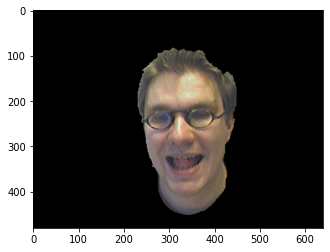

foreground pixels: 232197, background pixels: 37805
foreground pixels: 209938, background pixels: 60064
foreground pixels: 194005, background pixels: 75997


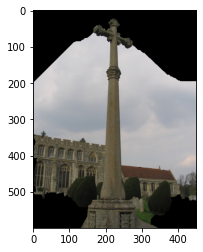

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log


foreground pixels: 25316, background pixels: 87718
foreground pixels: 24169, background pixels: 88865
foreground pixels: 23854, background pixels: 89180


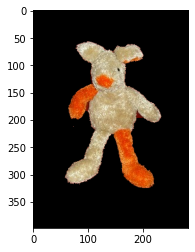

foreground pixels: 191290, background pixels: 115912
foreground pixels: 186572, background pixels: 120630
foreground pixels: 184314, background pixels: 122888


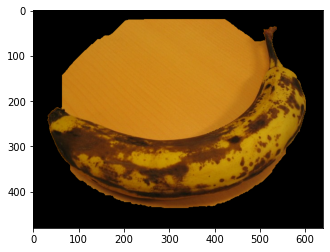

foreground pixels: 81813, background pixels: 188189
foreground pixels: 80073, background pixels: 189929
foreground pixels: 78530, background pixels: 191472


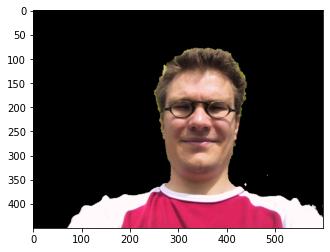

foreground pixels: 65151, background pixels: 204851
foreground pixels: 47162, background pixels: 222840
foreground pixels: 46846, background pixels: 223156


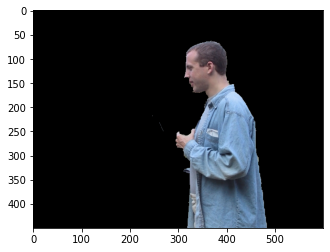

foreground pixels: 32837, background pixels: 157488
foreground pixels: 32147, background pixels: 158178
foreground pixels: 32137, background pixels: 158188


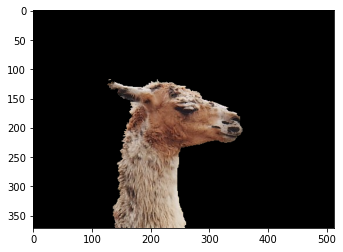

foreground pixels: 111030, background pixels: 196172
foreground pixels: 110846, background pixels: 196356
foreground pixels: 111051, background pixels: 196151


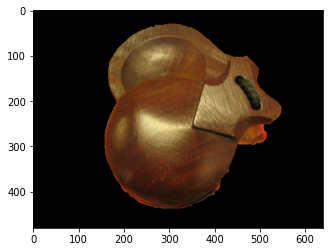

foreground pixels: 15145, background pixels: 254857
foreground pixels: 14926, background pixels: 255076
foreground pixels: 14680, background pixels: 255322


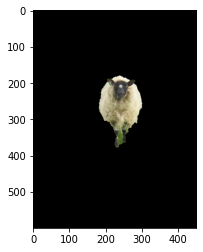

foreground pixels: 53527, background pixels: 216475
foreground pixels: 53185, background pixels: 216817
foreground pixels: 53171, background pixels: 216831


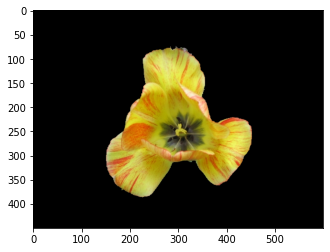

foreground pixels: 94579, background pixels: 159061
foreground pixels: 93839, background pixels: 159801
foreground pixels: 93650, background pixels: 159990


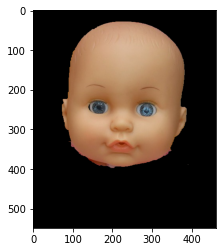

foreground pixels: 69988, background pixels: 164014
foreground pixels: 67736, background pixels: 166266
foreground pixels: 67605, background pixels: 166397


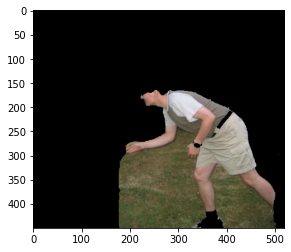

foreground pixels: 137307, background pixels: 169895
foreground pixels: 125480, background pixels: 181722
foreground pixels: 125186, background pixels: 182016


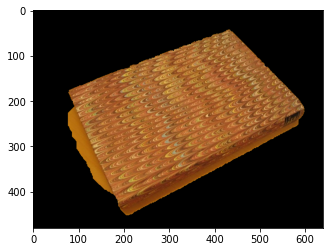

foreground pixels: 29992, background pixels: 206010
foreground pixels: 30865, background pixels: 205137
foreground pixels: 30865, background pixels: 205137


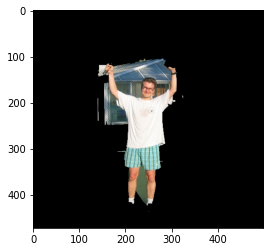

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log


foreground pixels: 10651, background pixels: 144051
foreground pixels: 9926, background pixels: 144776
foreground pixels: 9883, background pixels: 144819


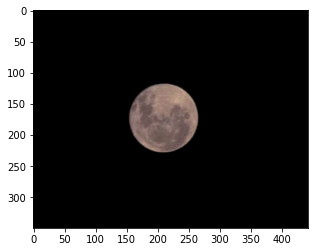

foreground pixels: 29676, background pixels: 240326
foreground pixels: 27480, background pixels: 242522
foreground pixels: 27022, background pixels: 242980


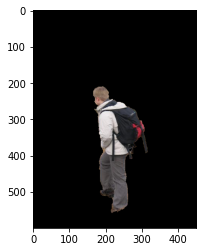

foreground pixels: 159245, background pixels: 147957
foreground pixels: 92758, background pixels: 214444
foreground pixels: 42030, background pixels: 265172


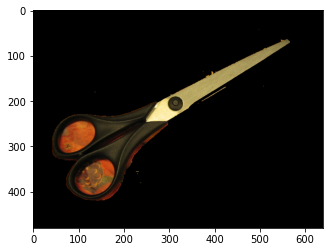

foreground pixels: 54112, background pixels: 215890
foreground pixels: 52733, background pixels: 217269
foreground pixels: 52410, background pixels: 217592


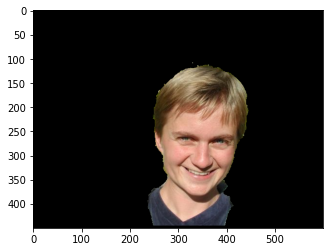

foreground pixels: 61206, background pixels: 245996
foreground pixels: 60576, background pixels: 246626
foreground pixels: 60445, background pixels: 246757


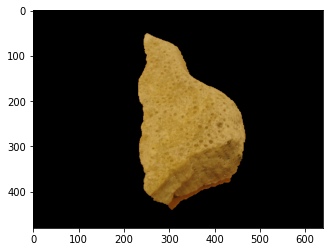

foreground pixels: 15409, background pixels: 254593
foreground pixels: 14875, background pixels: 255127
foreground pixels: 14883, background pixels: 255119


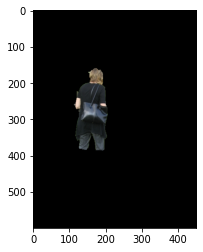

foreground pixels: 149716, background pixels: 157486
foreground pixels: 111905, background pixels: 195297
foreground pixels: 98950, background pixels: 208252


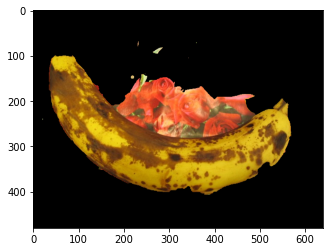

In [7]:
images = glob.glob("/content/images/*")

for img in images:
    input_img = cv2.imread(img)
    #cv2.imshow("img", input_img)
    #cv2.waitKey(500)
    #print(input_img.shape)
    bbox = img.split('/')
    bbox = bbox[-1]
    bbox = bbox.split('.')
    #print(bbox[0])
    bb_file = open("/content/bboxes/"+bbox[0]+".txt", "r")
    coord = bb_file.readline()
    coord = coord.split()
    #print(coord)
    p,q,r,s = int(coord[0]), int(coord[1]), int(coord[2]), int(coord[3])
    #rect = (q, p, abs(q-s), abs(p-r))  # (x,y,width, height) of rect
    rect = (p, q, abs(p-r), abs(q-s))  # (x,y,width, height) of rect
    #print(p,q,r,s)
    mask = np.zeros(input_img.shape[:2], dtype=np.uint8)
    #num_iterations = input("Enter number_of_iterations: ")
    num_iterations = 3
    gc_obj = Grabcut(input_img, mask, rect)
    gc_obj.run(int(num_iterations))
    output = gc_obj.modified_image()
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.show()
    #cv2.imshow('output', output)
    #k = cv2.waitKey()
    cv2.destroyAllWindows()

## Effect of varying number of iterations

Obseravations:

*   With increasing the number of iterations the image is getting better.
*   however with increasing iteration the improvement is very less.
*   After 3rd iteration there is not much visible difference.




    
    



foreground pixels: 149772, background pixels: 157430
Output after iteration  0 :


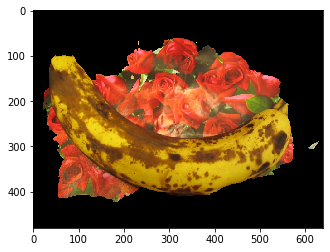

foreground pixels: 111904, background pixels: 195298
Output after iteration  1 :


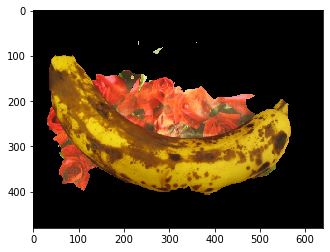

foreground pixels: 95644, background pixels: 211558
Output after iteration  2 :


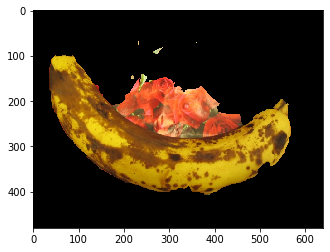

foreground pixels: 90912, background pixels: 216290
Output after iteration  3 :


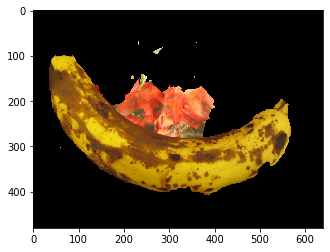

foreground pixels: 90862, background pixels: 216340
Output after iteration  4 :


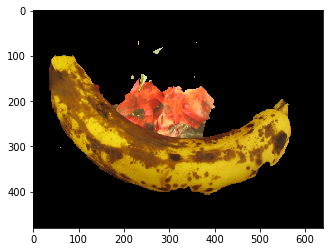

In [0]:
input_img = cv2.imread("./images/banana3.jpg")
img_copy = deepcopy(img)
bb_file = open("./bboxes/banana3.txt", "r")
coord = bb_file.readline()
coord = coord.split()
p,q,r,s = int(coord[0]), int(coord[1]), int(coord[2]), int(coord[3])
rect = (p, q, abs(p-r), abs(q-s))  # (x,y,width, height) of rect
mask = np.zeros(input_img.shape[:2], dtype=np.uint8)
gg = Grabcut(input_img, mask, rect)
iterations = 5
gg.run(iterations)
#output = gg.modified_image()

## Effect of varying number of GMM components

Observations:

*   The GMM seems to work for optimal number of 5 as suggested in paper. For fewer number of GMM's the grab cut is quite perfect but works poorly if components are too less.
*   For 8 component the grab cut is comparitevely poorer.
*   One reason can be that the distribution is better modelled for less number of components.











foreground pixels: 42013, background pixels: 227989
foreground pixels: 39738, background pixels: 230264
foreground pixels: 38405, background pixels: 231597
Output with  2  GMM components :


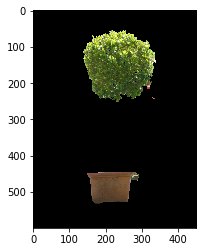

foreground pixels: 76323, background pixels: 193679
foreground pixels: 70466, background pixels: 199536
foreground pixels: 70439, background pixels: 199563
Output with  3  GMM components :


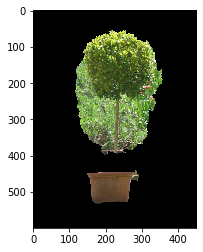

foreground pixels: 74329, background pixels: 195673
foreground pixels: 42601, background pixels: 227401
foreground pixels: 41638, background pixels: 228364
Output with  5  GMM components :


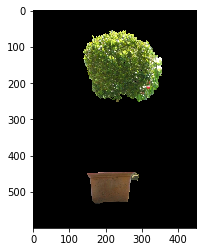

foreground pixels: 80597, background pixels: 189405
foreground pixels: 69205, background pixels: 200797
foreground pixels: 47235, background pixels: 222767
Output with  8  GMM components :


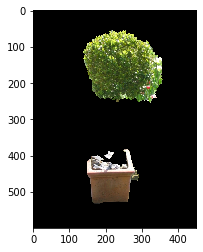

In [0]:
input_img = cv2.imread("./images/bush.jpg")
img_copy = deepcopy(input_img)
bb_file = open("./bboxes/bush.txt", "r")
coord = bb_file.readline()
coord = coord.split()
p,q,r,s = int(coord[0]), int(coord[1]), int(coord[2]), int(coord[3])
rect = (p, q, abs(p-r), abs(q-s))  # (x,y,width, height) of rect
mask = np.zeros(input_img.shape[:2], dtype=np.uint8)
num_gmm_comp = [2,3,5,8]
for num_comp in num_gmm_comp:
    gg = Grabcut(img_copy, mask, rect, num_gmm=num_comp, )
    gg.run(num_iters=3)
    output = gg.modified_image()
    print("Output with ", num_comp," GMM components :")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.show()

## 4 Neighbourhood vs 8 Neighbourhood

Observations :
    
*   The grab cut is better for 8 neighbour.
*   More neighbour is making the graph comapritevely dense thus resulting in better cut.


foreground pixels: 61285, background pixels: 245917
foreground pixels: 61053, background pixels: 246149
foreground pixels: 61017, background pixels: 246185
Output with 4 neighbours :


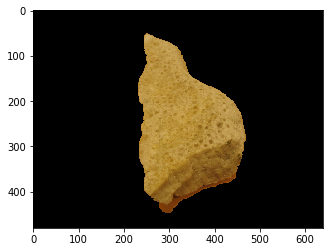

foreground pixels: 61220, background pixels: 245982
foreground pixels: 60590, background pixels: 246612
foreground pixels: 60462, background pixels: 246740
Output with 8 neighbours :


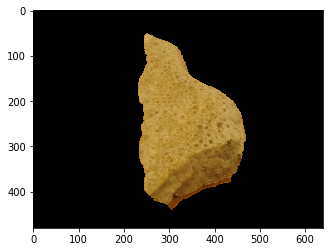

In [0]:
input_img = cv2.imread("./images/stone1.jpg")
img_copy = deepcopy(input_img)
bb_file = open("./bboxes/stone1.txt", "r")
coord = bb_file.readline()
coord = coord.split()
p,q,r,s = int(coord[0]), int(coord[1]), int(coord[2]), int(coord[3])
rect = (p, q, abs(p-r), abs(q-s))  # (x,y,width, height) of rect
mask = np.zeros(input_img.shape[:2], dtype=np.uint8)

gg = Grabcut(img_copy, mask, rect, neighbors = 4)
gg.run(num_iters=3)
output = gg.modified_image()
print("Output with 4 neighbours :")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()

gg = Grabcut(img_copy, mask, rect, neighbors = 4)
gg.run(num_iters=3)
output = gg.modified_image()
print("Output with 8 neighbours :")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()

## Different Colour Spaces


Observations:

*   There is not much differnce by changing the color space
*   Although there can be cases where changing the color space will change the result





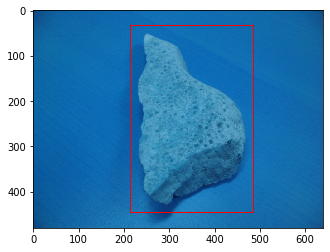

RGB
foreground pixels: 61257, background pixels: 245945
foreground pixels: 61059, background pixels: 246143


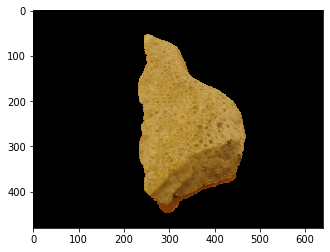

HSV
foreground pixels: 60643, background pixels: 246559
foreground pixels: 60450, background pixels: 246752


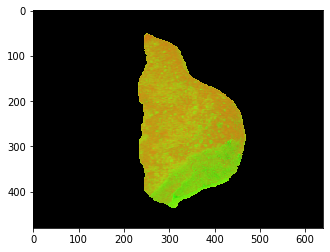

YUV
foreground pixels: 61150, background pixels: 246052
foreground pixels: 60537, background pixels: 246665


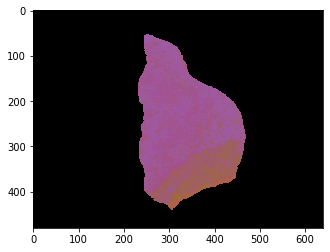

In [0]:
def diff_color_spaces(image, rect):
    gg = Grabcut(image, np.zeros(image.shape[:2], dtype=np.uint8), rect)
    gg.run()
    output = gg.modified_image()
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.show()
    
II = deepcopy(input_img)
cv2.rectangle(II, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (255, 0, 0), 2)
plt.imshow(cv2.cvtColor(II, cv2.COLOR_BGR2RGB))
plt.show()
print("RGB")
diff_color_spaces(img_copy, rect)
print("HSV")
diff_color_spaces(cv2.cvtColor(img_copy, cv2.COLOR_BGR2HSV), rect)
print("YUV")
diff_color_spaces(cv2.cvtColor(img_copy, cv2.COLOR_BGR2YUV), rect)